In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat

from torch import logsumexp
import sys
import time
import datetime
import math

In [2]:
Xs = torch.from_numpy(np.load('multishapes/biShapes.npy')).float()
Mus = torch.from_numpy(np.load('multishapes/biMus.npy')).float()
Zs = torch.from_numpy(np.load('multishapes/biZs.npy')).float()

num_seqs, N, D = Xs.shape
K = 2
## Model Parameters
NUM_SAMPLES = 50
NUM_HIDDEN = 32
NUM_LATENTS = 2
NUM_OBS = D
NUM_EPOCHS = 2000
BATCH_SIZE = 100
LEARNING_RATE = 1e-4
CUDA = True
PATH = 'oneshot-only-mus'

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_obs= NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.enc_mu = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.enc_log_sigma = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))

    def forward(self, obs):
        h = self.enc_h(obs) # (B, H)
        mu = self.enc_mu(h) # (B, 2)
        sigma = torch.exp(self.enc_log_sigma(h)) # (B, 2)
        q_u = Normal(mu, sigma)
        u = q_u.sample() # (B, 2)
        log_q_u = q_u.log_prob(u).sum(-1)
        return u, log_q_u
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.x_sigma = 0.1 * torch.ones(num_obs).cuda()
        self.dec_mu = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_obs))

    def forward(self, u, obs):
        mu = self.dec_mu(u) # (B, K) -> (B, O)
        Nk = mu.shape[1]
        p_x = Normal(mu, self.x_sigma) # (B, O)
        log_p_x = p_x.log_prob(obs).sum(-1) # (B)
        return mu, log_p_x

In [4]:
def initialize():
    enc_circle = Encoder().cuda()
    dec_circle = Decoder().cuda()
    
    enc_triangle = Encoder().cuda()
    dec_triangle = Decoder().cuda()

    return enc_circle, dec_circle, enc_triangle, dec_triangle
enc_circle, dec_circle, enc_triangle, dec_triangle = initialize()

In [5]:
enc_circle.load_state_dict(torch.load('VAE/enc-circle'))
enc_triangle.load_state_dict(torch.load('VAE/enc-triangle'))

dec_circle.load_state_dict(torch.load('VAE/dec-circle'))
dec_triangle.load_state_dict(torch.load('VAE/dec-triangle'))

In [6]:
class Encoder_global(nn.Module):
    def __init__(self, num_obs=D+K,
                       num_stats=10,
                       num_hidden=64,
                       num_latents=D*K):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_stats))

        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.mus_log_sigma = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        
    def forward(self, obs, N, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        q_mean = self.mus_mean(stats).view(-1, K, D)
        q_sigma = torch.exp(self.mus_log_sigma(stats).view(-1, K, D))
        q = Normal(q_mean, q_sigma)
        mus = q.sample((num_samples,))  # S * B * K * D
        log_q = q.log_prob(mus).sum(-1).sum(-1) # S * B
        return q_mean, q_sigma, mus, log_q ## mus_mean and mus_sigma are B * K * D

In [7]:
prior_mean = torch.zeros((BATCH_SIZE, K, D)).cuda()
prior_sigma = torch.ones((BATCH_SIZE, K, D)).cuda()

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

def E_step(X, mus, N, K, D):
    log_gammas = torch.zeros((K, N))
    for k in range(K):
        if k == 0:
            Xk = X - mus[k]
            u, log_q = enc_circle(Xk, 1)
            mu, log_p_x = dec_circle(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        else:
            Xk = X - mus[k]
            u, log_q = enc_triangle(Xk, 1)
            mu, log_p_x = dec_triangle(u, Xk, 1)
            log_gammas[k] = log_p_x[0]

    log_pis = log_gammas - logsumexp(log_gammas, 0)
    log_pis = log_pis.transpose(0,1)
    Z = rcat(temperature=torch.Tensor([0.066]), logits = log_pis).sample()
    log_gammas = log_gammas.transpose(0,1)
    labels = Z.argmax(-1)
    lls = log_gammas[torch.arange(N), labels].sum()
    return Z, lls

def log_joints(x, z, q_mean, q_sigma, mus, N, D, K, prior_mean, prior_sigma, num_samples, batch_size):
    log_pr = Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1) # S * B
    log_p_xs = torch.zeros((num_samples, batch_size)).cuda()
    for b in range(batch_size):
        xb = x[b]
        labels = z[b].argmax(-1)
        for k in range(K):
            ind = (labels == k).nonzero()[:, 0]
            xbk = xb[ind]
            Nk = xbk.shape[0]
            xbk = xbk.repeat(num_samples, 1, 1) - mus[:, b, k].unsqueeze(1).repeat(1, Nk, 1)
            if k == 0:
                u, log_q = enc_circle(xbk)
                mu, log_p_x = dec_circle(u, xbk)
                log_p_xs[:, b] = log_p_xs[:, b] + log_p_x.sum(-1)
#             elif k == 1:
#                 u, log_q = enc_square(xbk)
#                 mu, log_p_x = dec_square(u, xbk)
#                 log_p_xs[:, b] = log_p_xs[:, b] + log_p_x.sum(-1)
#             elif k == 2:
#                 u, log_q = enc_cross(xbk)
#                 mu, log_p_x = dec_cross(u, xbk)
#                 log_p_xs[:, b] = log_p_xs[:, b] + log_p_x.sum(-1)
            else:
                u, log_q = enc_triangle(xbk)
                mu, log_p_x = dec_triangle(u, xbk)    
                log_p_xs[:, b] = log_p_xs[:, b] + log_p_x.sum(-1)

    return log_p_xs + log_pr


def oneshot(x, z, N, K, D, num_samples, batch_size):
#     log_weights = torch.zeros((num_samples, batch_size)).cuda()

    data = torch.cat((x, z), dim=-1).view(batch_size*N, -1)
    q_mean, q_sigma, mus, log_q = enc_global(data, N, K, D, num_samples, batch_size)
    log_p = log_joints(x, z, q_mean, q_sigma, mus, N, D, K, prior_mean, prior_sigma, num_samples, batch_size)
    log_weights = log_p - log_q

    weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    ess = (1./ (weights ** 2).sum(0)).mean()
    ## EUBO and ELBO
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()

    return eubo, elbo, ess


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
enc_global = Encoder_global()
enc_global = enc_global.cuda()
# enc_global.apply(weights_init)
optimizer = torch.optim.Adam(list(enc_global.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [9]:
# for b in range(BATCH_SIZE):
#     xb = batch_Xs[b].cuda()
#     mus_true = Mus[b].cuda()
#     labels = batch_Zs[b].argmax(-1)
#     ind = (labels == 0).nonzero()[:, 0]
#     xbk = xb[ind] - mus_true[0]
#     u, log_q = enc_circle(xbk, 1)
#     mu, log_p_x = dec_circle(u, xbk, 1)
#     print(log_p_x.sum())


In [10]:
EUBOs = []
ELBOs = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    time_start = time.time()
    for step in range(num_batches):
        
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs[batch_indices]
        batch_Mus = Mus[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        batch_Xs = batch_Xs.cuda()
        batch_Zs = batch_Zs.cuda()
        eubo, elbo, ess = oneshot(batch_Xs, batch_Zs, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBOs.append(eubo.item())
        ELBOs.append(elbo.item())
    time_end = time.time()
    print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f (%ds)' % (epoch, eubo, elbo, ess, time_end - time_start))

        

epoch=0, EUBO=-6328.452148, ELBO=-34933.074219, ESS=1.000 (2s)
epoch=1, EUBO=-6696.302734, ELBO=-35685.308594, ESS=1.000 (2s)
epoch=2, EUBO=-5864.462402, ELBO=-33599.585938, ESS=1.000 (2s)
epoch=3, EUBO=-5132.111328, ELBO=-33866.183594, ESS=1.004 (2s)
epoch=4, EUBO=-4730.818359, ELBO=-34670.343750, ESS=1.000 (2s)
epoch=5, EUBO=-4081.028320, ELBO=-33843.597656, ESS=1.001 (2s)
epoch=6, EUBO=-4034.453613, ELBO=-34687.003906, ESS=1.000 (2s)
epoch=7, EUBO=-3600.889404, ELBO=-33092.300781, ESS=1.000 (2s)
epoch=8, EUBO=-3194.419678, ELBO=-35136.214844, ESS=1.000 (2s)
epoch=9, EUBO=-3839.887939, ELBO=-35916.875000, ESS=1.004 (2s)
epoch=10, EUBO=-2478.697021, ELBO=-33071.230469, ESS=1.003 (2s)
epoch=11, EUBO=-2690.906738, ELBO=-33273.320312, ESS=1.000 (2s)
epoch=12, EUBO=-2549.127930, ELBO=-34004.050781, ESS=1.000 (2s)
epoch=13, EUBO=-2727.445557, ELBO=-34411.652344, ESS=1.000 (2s)
epoch=14, EUBO=-2767.526123, ELBO=-34663.539062, ESS=1.000 (2s)
epoch=15, EUBO=-2831.798096, ELBO=-33497.808594, E

KeyboardInterrupt: 

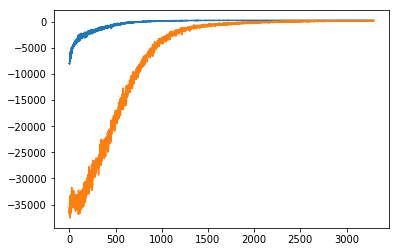

In [12]:
plt.plot(EUBOs)
plt.plot(ELBOs)
plt.savefig('naive encoder of circle and triangle given x and z.svg')

In [ ]:
plt.plot()

In [ ]:
colors = ['red', 'blue', 'green', 'gold']
for p in range(BATCH_SIZE):
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.set_xlim([-4,4])
    ax1.set_ylim([-4,4])
    ax2.set_xlim([-4,4])
    ax2.set_ylim([-4,4])
    x = batch_Xs[p]
    z = batch_Zs[p]
    mu = batch_Mus[p]
    labels = z.argmax(-1)
    for k in range(K):
        ax1.scatter(mu[k, 0].data.numpy(), mu[k, 1].data.numpy(), c=colors[k])
        ind = (labels == k).nonzero()[:, 0]
        xk = x[ind]
        zk = z[ind] 
        ax2.scatter(xk[:,0].data.numpy(), xk[:,1].data.numpy(), c=colors[k]) 

In [ ]:

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
# ax1.scatter(x[:, 0].data.numpy(), x[:, 1].data.numpy())
labels = z.argmax(-1)
for k in range(K):  
    ind = (labels == k).nonzero()[:, 0]
    xk = x[ind]
    zk = z[ind]
    ax1.scatter(xk[:,0].data.numpy(), xk[:,1].data.numpy(), c=colors[k])
#     ax2.plot(zk.data.numpy(), c=colors[k])

ax2.set_aspect('equal')
ax1.set_aspect('equal')

In [ ]:

mus = init_means()
Z, log_pis = E_step(Xs, mus, N, K, D)

labels = Z.argmax(-1)
mus = torch.zeros((K, D))
for k in range(K):
    labels_k = labels == k
    if labels_k.sum().item() == 0:
        continue
    else:
        mus[k] = Xs[labels_k].mean(0)

In [ ]:
mus

In [ ]:
labels = Z.argmax(-1)

In [ ]:
batch_Zs[2]